In [115]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [116]:
D1 = pd.read_csv("uci-news-aggregator.csv")
D1.head(2)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207


In [117]:
D1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         422419 non-null  int64 
 1   TITLE      422419 non-null  object
 2   URL        422419 non-null  object
 3   PUBLISHER  422417 non-null  object
 4   CATEGORY   422419 non-null  object
 5   STORY      422419 non-null  object
 6   HOSTNAME   422419 non-null  object
 7   TIMESTAMP  422419 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 25.8+ MB


In [118]:
Data = D1[["CATEGORY", "TITLE"]]

#Removing duplicates
Data.drop_duplicates(inplace = True)

#check for null values
Data.isnull().sum()

#drop null values
#Data = Data.dropna()

CATEGORY    0
TITLE       0
dtype: int64

(-1.101683995001352,
 1.1000801902381596,
 -1.109239778088433,
 1.1173873672681571)

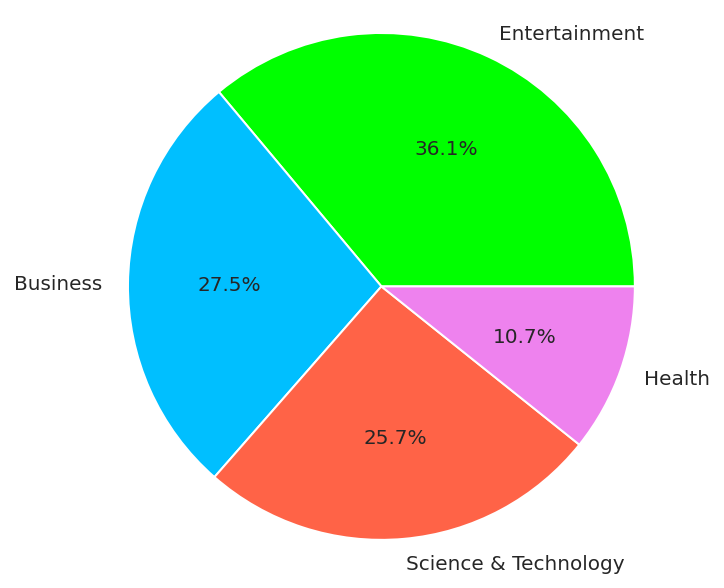

In [ ]:
Data = Data['CATEGORY'].value_counts().head(10)
#exp = [0.2,0,0,0]
labels = ['Entertainment', 'Business', 'Science & Technology', 'Health']
col = ['lime', 'deepskyblue','tomato','violet']

fig1, ax1 = plt.subplots(figsize=(5,5))
#ax1.pie(labels = labels, explode=exp, autopct = '%2.1f%%', colors = col, startangle=90)

ax1.pie(Data, labels=labels, autopct='%2.1f%%', colors = col)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [119]:
#Text Cleaning
import re
import string

def clean_text(TITLE):
    
    #Remove punctuations
    for ch in string.punctuation:
        TITLE = TITLE.replace(ch, " ")
    
    #Remove Unicode characters
    TITLE = re.sub(r'[^\x00-\x7F]+', '', TITLE)

    #Convert to lowercase to maintain consistency
    TITLE = TITLE.lower()
    
    #Remove white spaces
    TITLE = TITLE.strip()
    
    return TITLE

Data['TITLE'] = Data.TITLE.apply(lambda x: clean_text(x))

In [120]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [121]:
#Tokenization
import nltk
from nltk.tokenize import word_tokenize

Data['Tokenized']  = tuple(map(lambda x : nltk.word_tokenize(x),Data['TITLE']))

In [122]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [123]:
#Stop word removal
from nltk.corpus import stopwords 
stop = set(stopwords.words('english')) 

Data['Stopwords_removed'] = Data['Tokenized'].apply(lambda x: [word for word  in x if word not in stop ] )

In [124]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [125]:
#Lemmatization
from nltk.stem import WordNetLemmatizer

# Using Lemmatizer.
Lemmatizer = WordNetLemmatizer()

Data['Lemmatized'] = Data['Stopwords_removed'].apply(lambda x: [Lemmatizer.lemmatize(word) for word in x] )

In [126]:
Data.head(5)

,CATEGORY,TITLE,Tokenized,Stopwords_removed,Lemmatized
0,b,fed official says weak data caused by weather ...,"[fed, official, says, weak, data, caused, by, ...","[fed, official, says, weak, data, caused, weat...","[fed, official, say, weak, data, caused, weath..."
1,b,fed s charles plosser sees high bar for change...,"[fed, s, charles, plosser, sees, high, bar, fo...","[fed, charles, plosser, sees, high, bar, chang...","[fed, charles, plosser, see, high, bar, change..."
2,b,us open stocks fall after fed official hints ...,"[us, open, stocks, fall, after, fed, official,...","[us, open, stocks, fall, fed, official, hints,...","[u, open, stock, fall, fed, official, hint, ac..."
3,b,fed risks falling behind the curve charles ...,"[fed, risks, falling, behind, the, curve, char...","[fed, risks, falling, behind, curve, charles, ...","[fed, risk, falling, behind, curve, charles, p..."
4,b,fed s plosser nasty weather has curbed job gr...,"[fed, s, plosser, nasty, weather, has, curbed,...","[fed, plosser, nasty, weather, curbed, job, gr...","[fed, plosser, nasty, weather, curbed, job, gr..."


In [127]:
Data['PROCESSED_TITLE']  = Data['Lemmatized'].apply(lambda x : ' '.join(x))

In [128]:
Data = Data[["CATEGORY", "TITLE", "PROCESSED_TITLE"]]
Data.head(2)

,CATEGORY,TITLE,PROCESSED_TITLE
0,b,fed official says weak data caused by weather ...,fed official say weak data caused weather slow...
1,b,fed s charles plosser sees high bar for change...,fed charles plosser see high bar change pace t...


In [129]:
from sklearn.preprocessing import LabelEncoder

# pull the data into vectors
#tfidf2 = TfidfVectorizer()
#x = tfidf2.fit_transform(Data['PROCESSED_TITLE'])

x = Data['PROCESSED_TITLE']

encoder = LabelEncoder()
y = encoder.fit_transform(Data['CATEGORY'])

In [130]:
# split into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 117546, 0: 89518, 3: 83839, 2: 34942})
Counter({1: 29406, 0: 22385, 3: 20894, 2: 8777})


In [131]:
print("x_train dataset: ", x_train.shape[0])
print("y_train dataset: ", y_train.shape[0])

print("x_test dataset: ", x_test.shape[0])
print("y_test dataset: ", y_test.shape[0])

x_train dataset:  325845
y_train dataset:  325845
x_test dataset:  81462
y_test dataset:  81462


In [132]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [144]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

nb_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),)),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha = 0.01))])

#Train the model
nb_clf.fit(x_train, y_train)

#Predict the test cases using test data
pred_test = nb_clf.predict(x_test)
print (classification_report(y_test, pred_test))

NB_test = accuracy_score(y_test, pred_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy Score on Test Data:  %.2f" %(NB_test))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     22385
           1       0.98      0.98      0.98     29406
           2       0.96      0.94      0.95      8777
           3       0.93      0.94      0.94     20894

    accuracy                           0.95     81462
   macro avg       0.95      0.95      0.95     81462
weighted avg       0.95      0.95      0.95     81462

Accuracy Score on Test Data:  0.95
CPU times: user 26.5 s, sys: 590 ms, total: 27.1 s
Wall time: 27.1 s


In [141]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

LR_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),)),
                   ('tfidf', TfidfTransformer()),
                   ('LR', LogisticRegression(multi_class='ovr', random_state=42, solver="lbfgs")) ])

#Train the model
LR_clf.fit(x_train, y_train)

#Predict the test cases using test data
pred_test = LR_clf.predict(x_test)
print (classification_report(y_test, pred_test))

LR_test = accuracy_score(y_test, pred_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy Score on Test Data:  %.2f" % (LR_test))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     22385
           1       0.97      0.98      0.97     29406
           2       0.95      0.91      0.93      8777
           3       0.93      0.93      0.93     20894

    accuracy                           0.94     81462
   macro avg       0.94      0.94      0.94     81462
weighted avg       0.94      0.94      0.94     81462

Accuracy Score on Test Data:  0.94
CPU times: user 4min 23s, sys: 2min 7s, total: 6min 31s
Wall time: 3min 47s


In [137]:
%%time

from sklearn.svm import LinearSVC

LinSVC = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
                   ('tfidf', TfidfTransformer()),
                    ('LinSVC', LinearSVC(random_state=42, tol=1e-5))])

#Train the model
LinSVC.fit(x_train, y_train)

#Predict the test cases using test data
pred_test = LinSVC.predict(x_test)
print (classification_report(y_test, pred_test))

LinSVC_test = accuracy_score(y_test, pred_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy Score on Test Data:  %.2f" % (LinSVC_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     22385
           1       0.98      0.98      0.98     29406
           2       0.96      0.95      0.96      8777
           3       0.94      0.95      0.95     20894

    accuracy                           0.96     81462
   macro avg       0.96      0.96      0.96     81462
weighted avg       0.96      0.96      0.96     81462

Accuracy Score on Test Data:  0.96
CPU times: user 49.7 s, sys: 879 ms, total: 50.6 s
Wall time: 50.5 s


In [142]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["ALgorithm", "Test Accuracy"]

x.add_row(["Naive Bayes", " %.2f" % (NB_test)])
x.add_row(["Logistic Regression", " %.2f" % (LR_test)])
x.add_row(["Linear SVC", " %.2f" % (LinSVC_test)])

print(x)

+---------------------+---------------+
|      ALgorithm      | Test Accuracy |
+---------------------+---------------+
|     Naive Bayes     |      0.95     |
| Logistic Regression |      0.94     |
|      Linear SVC     |      0.96     |
+---------------------+---------------+
